In [100]:
!pip install -Uqq pyts fastbook binance-connector pandas_ta

In [1]:
# Import necessary libraries
import datetime as dt
import os
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import pandas as pd
import pandas_ta as ta
import pywt
import pywt.data
import re
from pyts.image import GramianAngularField
from PIL import Image as im
from binance.spot import Spot
%matplotlib inline 

import fastbook
fastbook.setup_book()
from fastbook import *
import matplotlib.image

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [102]:
#pywt.wavelist('sym')

In [103]:
SYMBOL = 'BTCUSDT'
INTERVAL = '1m'
INPUT_SIZE = 30
RAW_INPUT_SIZE = 100
THRESHOLD = 0.97
TRADING_PERCENT = 0.1
INITIAL_USD_BALANCE = 1000
STOP_PROFIT = 0.004
STOP_LOSS = 0.004
ORDER_LIFE = 5
TALIB_OFFSET = 33

In [104]:
def to_dataframe(data):
   np_data = np.array(data)
   df = pd.DataFrame(data=np_data[:, 1:6],
                     index=np_data[:, 0],
                     columns=np_data[0, 1:6])
   df.columns = ['open', 'high', 'low', 'close', 'volume']
   df['open'] = pd.to_numeric(df['open'])
   df['high'] = pd.to_numeric(df['high'])
   df['low'] = pd.to_numeric(df['low'])
   df['close'] = pd.to_numeric(df['close'])
   df['volume'] = pd.to_numeric(df['volume'])


In [105]:
rest_client = Spot()
START_TIME = 0
def prepare_dataset():
    first_data = rest_client.klines(SYMBOL, INTERVAL, limit=500)
    df = to_dataframe(first_data)
    startTime = 4
    #while endTime > START_TIME:
    #    data = rest_client.klines(SYMBOL, INTERVAL, limit=500)

In [106]:
wavelet_type = 'sym15'
w = pywt.Wavelet(wavelet_type)
def denoise(data):
    if len(data) > 0:
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        coeffs = pywt.wavedec(data, wavelet_type, level=maxlev)
        coeffs[-1] = np.zeros_like(coeffs[-1])
        datarec = pywt.waverec(coeffs, wavelet_type)
        return datarec
    else:
        return data

In [107]:
BTC = pd.read_csv("../input/bitcoin-btcusdt/Bitcoin_BTCUSDT.csv")
df = BTC.iloc[-10000:].reset_index(drop=True)

In [108]:

def calc_label(dataset, position):
    price = dataset['close'].to_numpy()[position]
    stop_loss = STOP_LOSS * price
    stop_profit = STOP_PROFIT * price
    label = "wait"
    bearish_stop_loss = price + stop_loss
    bearish_stop_profit = price - stop_profit
    bullish_stop_loss = price - stop_loss
    bullish_stop_profit = price + stop_profit
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if low_price > bullish_stop_loss:
            if max_price >= bullish_stop_profit:
                label = "buy"
                break
        else:
            break
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if max_price < bearish_stop_loss:
            if low_price <= bearish_stop_profit:
                label = "sell"
                break
        else:
            break
    return label
        
       

    

In [109]:
L = len(df['close'])
df_labels = [None]*L
for i in range(0, L-ORDER_LIFE):
    df_labels[i] = calc_label(df, i)

df_labeled_raw = df.copy()
df_labeled_raw['label'] = df_labels

In [110]:
df_labeled_raw[150:300]

,timestamp,open,high,low,close,volume,label
150,2022-05-16 16:16:00,29395.11,29395.12,29353.08,29363.26,65.31633,wait
151,2022-05-16 16:17:00,29363.25,29395.12,29321.99,29343.82,82.56491,buy
152,2022-05-16 16:18:00,29343.82,29448.89,29315.24,29448.81,157.70268,wait
153,2022-05-16 16:19:00,29448.81,29470.58,29421.80,29449.74,63.57436,wait
154,2022-05-16 16:20:00,29449.99,29478.43,29434.47,29449.06,53.66338,wait
...,...,...,...,...,...,...,...
295,2022-05-16 18:41:00,29897.77,29902.35,29872.71,29887.70,22.79386,wait
296,2022-05-16 18:42:00,29887.69,29914.69,29887.69,29903.35,23.05728,wait
297,2022-05-16 18:43:00,29903.35,29924.94,29903.34,29904.90,40.32597,wait
298,2022-05-16 18:44:00,29904.91,29904.91,29860.00,29865.40,81.85236,wait


In [111]:


df = df_labeled_raw.iloc[:-ORDER_LIFE].reset_index(drop=True).copy()

In [112]:
DS_LENGTH = len(df['close'])
df

,timestamp,open,high,low,close,volume,label
0,2022-05-16 13:46:00,29672.83,29699.21,29531.56,29562.10,196.41880,wait
1,2022-05-16 13:47:00,29562.11,29630.00,29546.78,29587.17,127.45077,sell
2,2022-05-16 13:48:00,29587.17,29620.72,29523.32,29564.96,129.19324,buy
3,2022-05-16 13:49:00,29564.96,29607.93,29535.32,29572.31,132.21620,sell
4,2022-05-16 13:50:00,29572.30,29599.67,29450.00,29590.17,306.23555,wait
...,...,...,...,...,...,...,...
9990,2022-05-23 12:16:00,30533.76,30598.99,30533.75,30582.41,60.43965,wait
9991,2022-05-23 12:17:00,30582.40,30593.73,30577.47,30593.72,22.95281,wait
9992,2022-05-23 12:18:00,30593.73,30625.98,30569.96,30572.25,117.82663,wait
9993,2022-05-23 12:19:00,30572.25,30572.62,30539.06,30539.62,30.19423,wait


In [113]:
input_open = [None]*DS_LENGTH
input_high = [None]*DS_LENGTH
input_low = [None]*DS_LENGTH
input_close = [None]*DS_LENGTH
input_volume = [None]*DS_LENGTH
input_timestamp = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    if i + 1 >= RAW_INPUT_SIZE:
        input_open[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].open
        input_high[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].high
        input_low[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].low
        input_close[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].close
        input_volume[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].volume
        input_timestamp[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].timestamp.copy().reset_index(drop=True)
df['input_open'] = input_open
df['input_high'] = input_high
df['input_low'] = input_low
df['input_close'] = input_close
df['input_volume'] = input_volume
df['input_timestamp'] = input_timestamp
df = df.iloc[RAW_INPUT_SIZE:].copy().reset_index(drop=True)


In [114]:
df = df[df['label'] != 'wait'].reset_index(drop=True)

In [115]:
print(df['input_timestamp'][0])

0     2022-05-16 13:51:00
1     2022-05-16 13:52:00
2     2022-05-16 13:53:00
3     2022-05-16 13:54:00
4     2022-05-16 13:55:00
             ...         
95    2022-05-16 15:26:00
96    2022-05-16 15:27:00
97    2022-05-16 15:28:00
98    2022-05-16 15:29:00
99    2022-05-16 15:30:00
Name: timestamp, Length: 100, dtype: object


In [117]:
DS_LENGTH = len(df['close'])
denoised_input_open = [None]*DS_LENGTH
denoised_input_high = [None]*DS_LENGTH
denoised_input_low = [None]*DS_LENGTH
denoised_input_close = [None]*DS_LENGTH
denoised_input_volume = [None]*DS_LENGTH

for i in range(0, DS_LENGTH):
    denoised_input_open[i] = denoise(df['input_open'][i])
    denoised_input_high[i] = denoise(df['input_high'][i])
    denoised_input_low[i] = denoise(df['input_low'][i])
    denoised_input_close[i] = denoise(df['input_close'][i])
    denoised_input_volume[i] = denoise(df['input_volume'][i])

df['denoised_input_open'] = denoised_input_open
df['denoised_input_high'] = denoised_input_high
df['denoised_input_low'] = denoised_input_low
df['denoised_input_close'] = denoised_input_close
df['denoised_input_volume'] = denoised_input_volume

In [ ]:
ind_list = df.ta.indicators(as_list=True)
ind_columns = []

In [ ]:
for indi in ind_list:
    try:
        indi_data = [{}]*DS_LENGTH
        for i in range(0, DS_LENGTH):
            indi_df = df[['denoised_input_open', 'denoised_input_high', 'denoised_input_low',
                          'denoised_input_close', 'denoised_input_volume']][i].copy()
            indi_df = indi_df.rename(columns={"denoised_input_open": "open", "denoised_input_high": "high",
                                     "denoised_input_low": "low", "denoised_input_close": "close", "denoised_input_volume": "volume"})
            indi_df['timestamp'] = df['input_timestamp'][i].copy(
            ).reset_index(drop=True)
            indi_df.set_index(pd.DatetimeIndex(
                indi_df["timestamp"]), inplace=True)
            indi_fn = getattr(df.ta, indi)
            data = indi_fn()
            new_cols = data.columns.tolist()
            ind_columns = ind_columns + new_cols
            for col_name in new_cols:
                indi_data[i][col_name] = data[col_name]
        df_indi = pd.DataFrame(indi_data).reset_index(drop=True)
        df.merge(df_indi, left_index=True, right_index=True)
    except Exception as e:
        #print(e)


In [ ]:
df['input_close'][120].plot.line()

In [ ]:
pd.Series(df['denoised_input_close'][120]).plot.line()

In [119]:
gaf_transformer = GramianAngularField(method='difference', image_size=INPUT_SIZE)
df_gaf_input_open = [None]*DS_LENGTH
df_gaf_input_high = [None]*DS_LENGTH
df_gaf_input_low = [None]*DS_LENGTH
df_gaf_input_close = [None]*DS_LENGTH
df_gaf_input_volume = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    if len(df['denoised_input_close'][i]) > 0:
        df_gaf_input_open[i] = gaf_transformer.fit_transform(df['denoised_input_open'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_high[i] = gaf_transformer.fit_transform(df['denoised_input_high'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_low[i] = gaf_transformer.fit_transform(df['denoised_input_low'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_close[i] = gaf_transformer.fit_transform(df['denoised_input_open'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_volume[i] = gaf_transformer.fit_transform(df['denoised_input_volume'][i][-INPUT_SIZE:].reshape(1, -1))
df['gaf_open'] = df_gaf_input_open
df['gaf_high'] = df_gaf_input_high
df['gaf_low'] = df_gaf_input_low
df['gaf_close'] = df_gaf_input_close
df['gaf_volume'] = df_gaf_input_volume


In [ ]:
for col_name in ind_columns:
    gaf_col = [None]*DS_LENGTH
    for i in range(0, DS_LENGTH):
        if len(df['denoised_input_close'][i]) > 0:
            gaf_col[i] = gaf_transformer.fit_transform(
                df[col_name][i][-INPUT_SIZE:].reshape(1, -1))
    df[col_name] = gaf_col

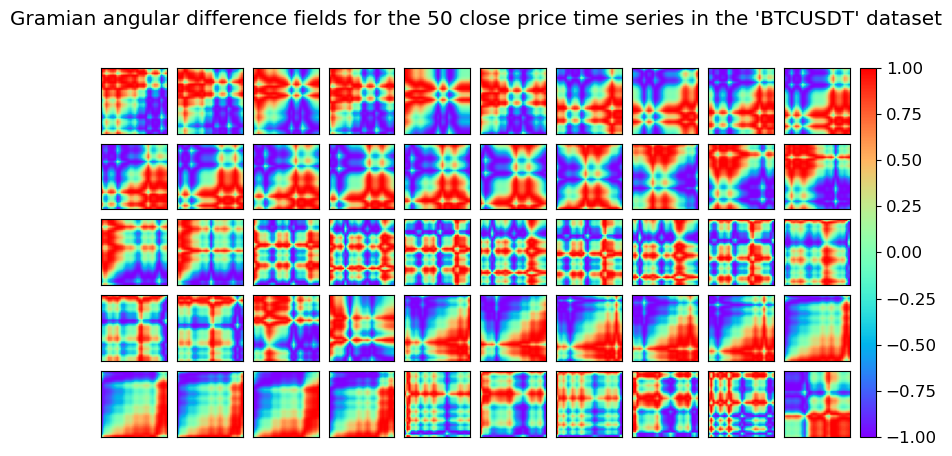

In [124]:
fig = plt.figure(figsize=(10, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    image_item = ax.imshow(df['gaf_open'].to_numpy()[i+10].squeeze(), cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(image_item, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("Gramian angular difference fields for the 50 close price time series in the "
             "'BTCUSDT' dataset")
plt.show()

In [126]:
df_train = df
pat = r'^(.*)_\d+.png'
images_path = '/kaggle/working/images/'
if not os.path.exists(images_path):
   os.makedirs(images_path)
for ind_col_name in ind_columns:
   files = get_image_files(images_path)
   for f in files:
      os.remove(f)
   L = len(df_train['close'])
   for i in range(0, L):
      i_open = df_train['gaf_open'].to_numpy()[i].squeeze()
      i_high = df_train['gaf_high'].to_numpy()[i].squeeze()
      i_low = df_train['gaf_low'].to_numpy()[i].squeeze()
      i_close = df_train['gaf_close'].to_numpy()[i].squeeze()
      i_volume = df_train['gaf_volume'].to_numpy()[i].squeeze()
      i_ind_col = df_train[ind_col_name].to_numpy()[i].squeeze()
      row1 = np.concatenate([i_open, i_high, i_low])
      row2 = np.concatenate([i_close, i_volume, i_ind_col])
      row3 = np.concatenate([i_close, i_volume, i_ind_col])
      data = np.concatenate([row1, row2, row3], axis=1)
      label = df_train['label'].to_numpy()[i]
      matplotlib.image.imsave(images_path + label + '_' + str(i) + '.png', data)
   files = get_image_files(images_path)
   print(files)
   dls = ImageDataLoaders.from_name_re(images_path, files, pat)
   dls.show_batch()
   learn = vision_learner(dls, resnet101, metrics=error_rate)  # resnet152
   #learn.lr_find()
   learn.fine_tune(10, 0.0002290867705596611)
   #learn.show_results()
   #learn.predict(files[0])


In [ ]:
#learn.export(fname='/kaggle/working/model.pkl')
